<a href="https://colab.research.google.com/github/yaobviously/DFSProjections/blob/master/FPClassifierModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
file = '/content/Players2019.csv'
!pip install category_encoders

In [45]:
url = r'https://raw.githubusercontent.com/yaobviously/PlayerFPClassifier/main/Players2019.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error

In [19]:
def wrangle(filename):
    
    df = pd.read_csv(file,
                     parse_dates = ['Date'],
                     index_col = 'Date')
    
    # dropping some useless columns from lazy .to_csv'ing early on

    df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 
                       'predFP', 'residual', 'PlayerID'],
                        inplace = True)
    
    # renaming and reformatting column headers for easier access

    df.rename(columns = {'BIGDATABALL\nDATASET' : 'Game_Type'}, inplace = True)
    
    df.columns = df.columns.str.lower()
    
    # defining the targets of the models

    df['boom_threshold'] = df['fppgame'] + 9
    df['boom_threshold'] = df['boom_threshold'].fillna(1)
    df['didboom'] = (df['playerfp'] >= df['boom_threshold']).astype(int)    
    df['didntbust'] = df['playerfp'] >= df['fppgame']
    
    # i originally did some work in statsmodels, but left it out

    df['hora'] = df['hora'].astype('category')
    df['daysrest'] = df['daysrest'].astype('category')
    df['team'] = df['team'].astype('category')
    
    # defining new columns using rolling and expanding averages that have been
    # shifted to only include observations prior to the date of the box score

    df['rollingmpg'] = df.groupby('player')['min'].transform(lambda x: x.rolling(5).mean().shift())
    df['expandingmpg'] = df.groupby('player')['min'].transform(lambda x: x.expanding().mean().shift())
    df['rolling_min_diff'] = df['rollingmpg'] - df['expandingmpg']
    df['fpdifferential'] = df['playerfp'] - df['fppgame']
    
    reg = df[df['game_type'] == 'NBA 2019-2020 Regular Season'].copy()
    ply = df[df['game_type'] == 'NBA 2020 Playoffs'].copy()    
    
    return reg, ply

In [46]:
reg, ply = wrangle(url)


In [26]:
# Defining a cutoff date to separate the data into train and test sets. Two
# additional filters were defined and tested, but the most general is the 
# date-only model


date_threshold = '2020-01-15'
#rank_threshold = 7.0
#fppg_threshold = 18.0

early_mask = reg.index < date_threshold
#fppg_mask = reg['fppgame'] >= fppg_threshold
#rank_mask = reg['fpteamrank'] >= rank_threshold


features = ['fp/minsofar', 'fpteamrank', 'rolling_min_diff', 'gmmlabel', 'rollinggmmdeltad',
            'opponent', 'stdtodate', 'fppgame', 'teamvegas', 'closingspread']

target = 'didntbust'

# splitting the data into test and train sets using the date filter and 
# minimum fantasy points per game filters. 

X = reg[features]
X = X.replace([np.inf, -np.inf], np.nan)

y = reg[target]

X_train, y_train = X[early_mask], y[early_mask]
X_test, y_test = X[~early_mask], y[~early_mask]


In [17]:
# SVC model fitting and evaluation. The linear kernel performs best.

model_svc = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(strategy = 'mean'),
    StandardScaler(),
    SVC(kernel = 'linear', probability = True, gamma = 'auto')
    )


model_svc.fit(X_train, y_train)

svc_predict = model_svc.predict(X_test)
svc_prob_predict = model_svc.predict_proba(X_test)
svc_prob_didntbust = svc_prob_predict[:,1];

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [18]:
# evaluating the model. this one doesn't do too well, which isn't surprising

svc_roc = roc_auc_score(y_test, svc_predict)
svc_precision = precision_score(y_test, svc_predict)
svc_recall = recall_score(y_test, svc_predict)
svc_f1 = f1_score(y_test, svc_predict)


The model predicts a boom 0.421 percent of the time


In [ ]:
# Creating the RandomForestClassifier pipeline and later fitting it using the
# optimal parameters found with RandomizedSearchCV

rf_model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(strategy = 'mean'),
    StandardScaler(),
    RandomForestClassifier(n_estimators = 312, min_samples_split = 10, max_features = 'sqrt')
    )


rf_model.fit(X_train, y_train);


In [ ]:
# Finding he optimal parameters for the RandomForest Classifier using 
# RandomizedSearch

n_estimators = [int(n) for n in np.linspace(50,500, 25)]
min_samples_split = [2,5,10]
max_features =  ['auto', 'sqrt']

# To remember for later, the two underscores are necessary when defining params
# for a model within a pipeline

random_grid = {'randomforestclassifier__n_estimators':n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__min_samples_split': min_samples_split,
               }

search = RandomizedSearchCV(rf_model, n_iter = 10, cv = 3, refit = False,
                            verbose = 2, param_distributions= random_grid)

search.fit(X_train, y_train);

print(search.best_params_)

In [43]:
# Evaluating the RandomForestClassifier

rf_predict = rf_model.predict(X_test)
rf_predict_proba = rf_model.predict_proba(X_test)[:,1]

rf_roc_score = roc_auc_score(y_test, rf_predict)
rf_f1_score = f1_score(y_test, rf_predict)
rf_precision_score = precision_score(y_test, rf_predict)
rf_recall_score = recall_score(y_test, rf_predict)

# Adding the predicted values onto the dataframe to do a superficial inspection.
# Look at all those 'booms' near the top (base rate of booms = ~21%)! Better than
# the opposite

rf_test = reg[~early_mask]
rf_test['notbust_pred'] = (rf_predict_proba).round(3)
rf_test[['player', 'playerfp', 'notbust_pred', 'didntbust', 'didboom']].sort_values(by = 'notbust_pred', ascending=False).head(30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,player,playerfp,notbust_pred,didntbust,didboom
Date,,,,,
2020-08-13,Troy Brown Jr.,42.00,0.785,True,1
2020-02-23,Coby White,54.50,0.776,True,1
2020-01-22,Nemanja Bjelica,36.75,0.775,True,0
2020-01-27,Kris Dunn,39.50,0.766,True,1
2020-03-02,Tim Hardaway Jr.,36.75,0.763,True,1
2020-02-10,Bruce Brown,35.50,0.758,True,1
2020-08-13,Tim Hardaway Jr.,11.50,0.758,False,0
2020-08-14,Aaron Holiday,24.00,0.755,True,0
2020-03-08,Tim Hardaway Jr.,46.00,0.754,True,1


Text(0.5, 1.0, 'Boom % Versus Predicted Bust %')

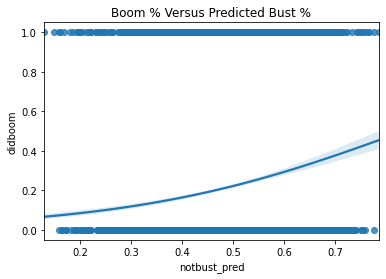

In [33]:
# The probability of a 'boom' outcome increases in the expected way, which is 
# nice. 

sns.regplot(x = 'notbust_pred', y='didboom', logistic = True, data = rf_test)
plt.title('Booms Versus Predicted Predicted Not Bust%');

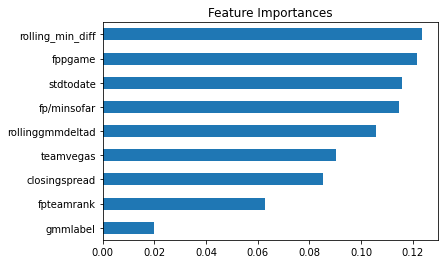

In [39]:
# Plotting the relative importance of features using a standard horizontal 
# bar chart. A  better feature would be a reliable minutes 
# projection, but I did not have one in the data set and settled for 
# the differential between the rolling 5 game average and the expanding average.

feature_names = rf_model.named_steps['onehotencoder'].get_feature_names()
feature_importances = rf_model.named_steps['randomforestclassifier'].feature_importances_.ravel()
features = pd.Series(feature_importances, index = feature_names).sort_values(key = abs, ascending = False).head(9)

features.sort_values(key = abs).plot.barh()
plt.title('Feature Importances');
